### Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix , accuracy_score , precision_score , recall_score , f1_score

from sklearn.pipeline import Pipeline

from sklearn.feature_selection import mutual_info_regression, SelectPercentile, chi2, f_classif, SelectKBest

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.experimental import enable_halving_search_cv

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBClassifier

from scipy.stats import chi2_contingency

In [4]:
from joblib import Parallel, delayed

In [5]:
import joblib

### Import Dataset

In [6]:
# import the csv
model_train = pd.read_csv('dataset_B_05_2020.csv')

### Feature Engineering

model_train['total_special_chars'] = model_train[['nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 
                                                  'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 
                                                  'nb_colon', 'nb_comma', 'nb_semicolumn', 'nb_dollar', 'nb_space']].sum(axis=1)

In [7]:
#model_train['sum_common_terms'] = model_train['nb_www'] + model_train['nb_com'] + model_train['nb_dslash'] + model_train['http_in_path']

### Encoding

In [8]:
lb = LabelBinarizer()

In [9]:
# Transform status column to binary labels
model_train['status'] = lb.fit_transform(model_train['status'])

### Select Numerical Features

In [10]:
numerical_features = model_train.select_dtypes(include=np.number).columns.tolist()

In [11]:
numerical_features.pop(-1)

'status'

### Scale

In [12]:
# Create a StandardScaler object
scaler = StandardScaler()
scaler.fit(model_train[numerical_features])
scaled_features = scaler.transform(model_train[numerical_features])

In [13]:
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [14]:
model_train[numerical_features] = scaled_features

### Correlation

In [15]:
corr_matrix = model_train.corr()

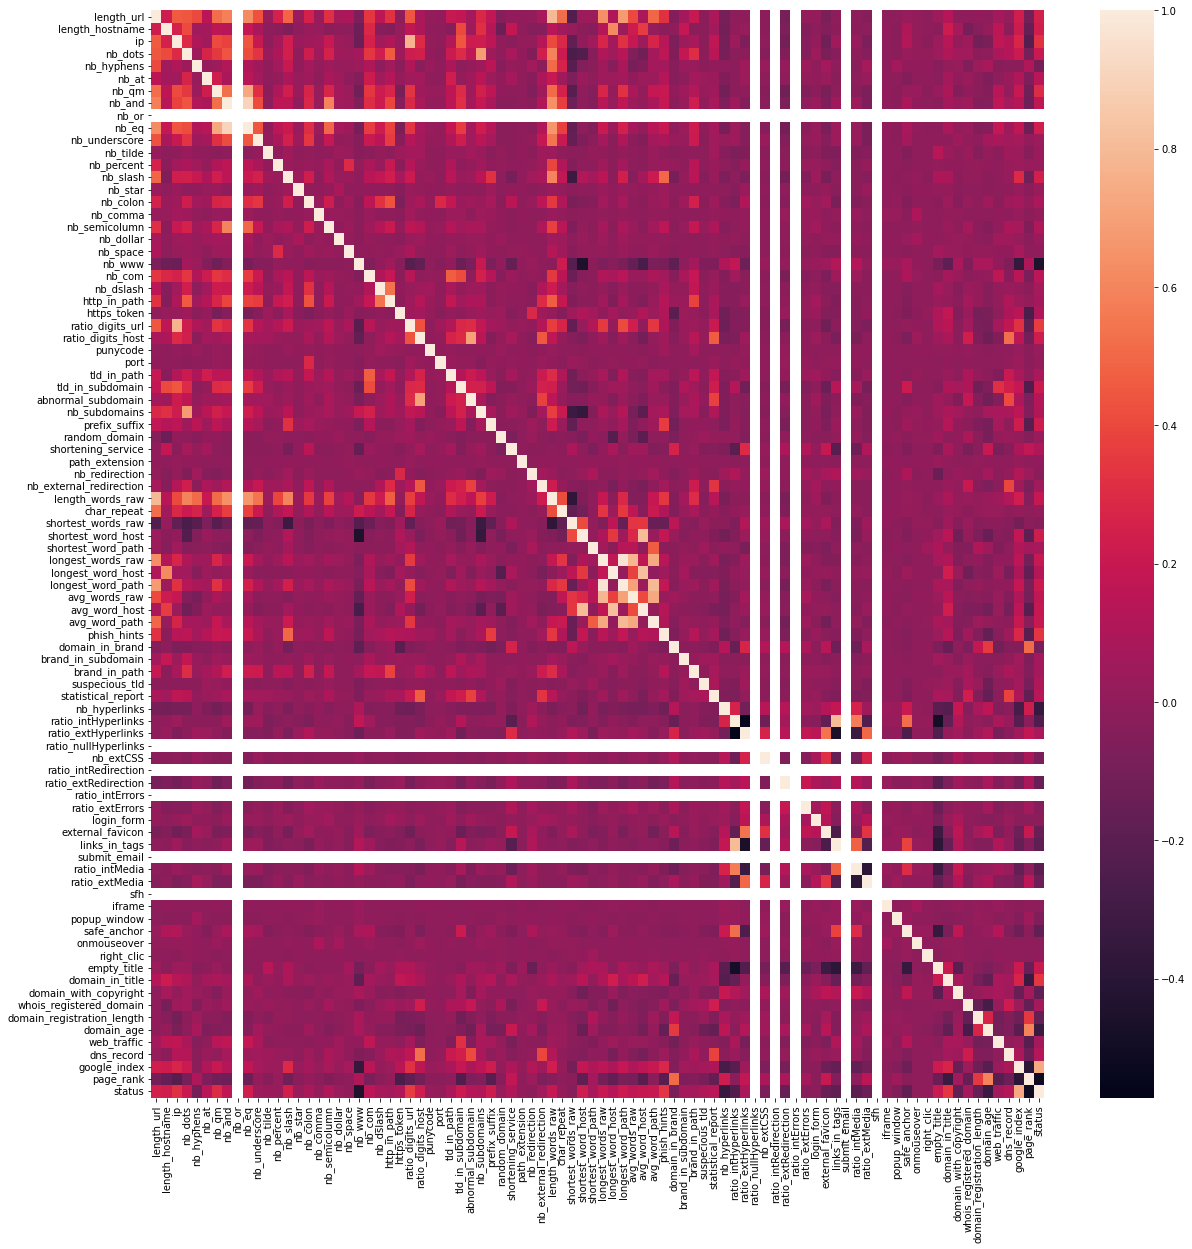

In [16]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(20,20))

# Create heatmap
sns.heatmap(corr_matrix, annot=False, ax=ax)

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Show plot
plt.show()

### Split into Train and Test

In [17]:
X = model_train.drop(['url', 'status'], axis=1)
y = model_train['status']

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=3, shuffle=True)

### MODEL CLASS

In [19]:
class ModelTester:
    def __init__(self, X_train, y_train, cv=KFold(n_splits=5, shuffle=True, random_state=3)):
        self.X_train = X_train
        self.y_train = y_train
        self.cv = cv

    def test_models(self):
        models = {
            'SVM': SVC(),
            'Gaussian Naive Bayes': GaussianNB(),
            'Decision Tree': DecisionTreeClassifier(),
            'K-Nearest Neighbors': KNeighborsClassifier(),
            'Random Forest': RandomForestClassifier(),
            'Logistic Regression': LogisticRegression(),
            'Gradient Boosting': GradientBoostingClassifier(),
            'XGBoost': XGBClassifier()
        }
        
        evaluation_metrics = ['accuracy', 'f1', 'precision', 'recall']
        
        best_estimators = {}
        
        for model_name, model in models.items():
            pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('model', model)
            ])
            
            param_grid = {}
            
            if model_name == 'SVM':
                param_grid = {
                    'model__C': [0.1, 1, 10],
                    'model__kernel': ['linear', 'rbf', 'poly'],
                    'model__degree': [2, 3, 4],
                    'model__gamma': ['scale', 'auto']
                }
            elif model_name == 'Decision Tree':
                param_grid = {
                    'model__criterion': ['gini', 'entropy'],
                    'model__max_depth': [2, 4, 6, 8, 10, 12],
                    'model__min_samples_split': [2, 5, 10],
                    'model__min_samples_leaf': [1, 2, 4]
                }
            elif model_name == 'K-Nearest Neighbors':
                param_grid = {
                    'model__n_neighbors': [3, 5, 7, 9],
                    'model__weights': ['uniform', 'distance'],
                    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
                }
            elif model_name == 'Random Forest':
                param_grid = {
                    'model__n_estimators': [50, 100, 200],
                    'model__criterion': ['gini', 'entropy'],
                    'model__max_depth': [2, 4, 6, 8, 10, 12],
                    'model__min_samples_split': [2, 5, 10],
                    'model__min_samples_leaf': [1, 2, 4],
                    'model__bootstrap': [True, False]
                }
            elif model_name == 'Logistic Regression':
                param_grid = {
                    'model__C': [0.1, 1, 10],
                    'model__penalty': ['l1', 'l2'],
                    'model__solver': ['liblinear']
                }
            elif model_name == 'Gradient Boosting':
                param_grid = {
                    'model__learning_rate': [0.1, 0.05, 0.01],
                    'model__n_estimators': [50, 100, 200],
                    'model__max_depth': [2, 4, 6, 8, 10],
                    'model__min_samples_split': [2, 5, 10],
                    'model__min_samples_leaf': [1, 2, 4]
                }
            elif model_name == 'XGBoost':
                param_grid = {
                    'model__learning_rate': [0.1, 0.05, 0.01],
                    'model__n_estimators': [50, 100, 200],
                    'model__max_depth': [2, 4, 6, 8, 10],
                    'model__min_child_weight': [1, 3, 5],
                    'model__gamma': [0.0, 0.1, 0.2],
                    'model__subsample': [0.6, 0.8, 1.0],
                    'model__colsample_bytree': [0.6, 0.8, 1.0],
                    'model__reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]
                }
            else:
                param_grid = {}
        
            search = GridSearchCV(pipe, param_grid, cv=self.cv, scoring='accuracy', n_jobs=-1)
            search.fit(self.X_train, self.y_train)

            print(f"Best parameters for {model_name}:")
            print(search.best_params_)
            print(f"Best cross-validation score for {model_name}:")
            print(search.best_score_)
            print('\n')
            
            # evaluate each model
            y_pred = search.best_estimator_.predict(self.X_train)
            results = {}
            for metric in evaluation_metrics:
                if metric == 'accuracy':
                    results[metric] = accuracy_score(self.y_train, y_pred)
                elif metric == 'f1':
                    results[metric] = f1_score(self.y_train, y_pred, average='macro')
                elif metric == 'precision':
                    results[metric] = precision_score(self.y_train, y_pred, average='macro')
                elif metric == 'recall':
                    results[metric] = recall_score(self.y_train, y_pred, average='macro')
                    
            # print evaluation results for each model
            print(f"Evaluation results for {model_name}:")
            for metric, score in results.items():
                print(f"{metric}: {score}")
                
            print('\n')
            

            # save the best estimator for the current model
            best_estimators[model_name] = search.best_estimator_
        
        # save each best estimator using joblib
        for model_name, best_estimator in best_estimators.items():
            joblib.dump(best_estimator, f'{model_name}.joblib')
        
        return best_estimators

In [ ]:
model_tester = ModelTester(X_train, y_train)

# test all the models and store the best scores and estimators in a dictionary
best_scores = {}
best_estimators = {}
model_tester.test_models()
for model_name in best_scores.keys():
    pipe = model_tester.create_pipeline(model_name)
    search = model_tester.run_grid_search(pipe, model_name)
    best_scores[model_name] = search.best_score_
    best_estimators[model_name] = search.best_estimator_
    
    # evaluate the best estimator for the current model on the test set
    y_pred = best_estimators[model_name].predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    # print the evaluation metrics for the current model
    print(f"Evaluation metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print('\n')

Best parameters for SVM:
{'model__C': 10, 'model__degree': 2, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best cross-validation score for SVM:
0.960192940624727


Evaluation results for SVM:
accuracy: 0.9896106736657918
f1: 0.989610569166026
precision: 0.9896090187256242
recall: 0.989624642172126


Best parameters for Gaussian Naive Bayes:
{}
Best cross-validation score for Gaussian Naive Bayes:
0.6843860104587768


Evaluation results for Gaussian Naive Bayes:
accuracy: 0.6856955380577427
f1: 0.6578636996499672
precision: 0.7804014370549481
recall: 0.6873397201905149


Best parameters for Decision Tree:
{'model__criterion': 'gini', 'model__max_depth': 12, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10}
Best cross-validation score for Decision Tree:
0.9417106237580052


Evaluation results for Decision Tree:
accuracy: 0.9803149606299213
f1: 0.9803149455623186
precision: 0.9803336002824494
recall: 0.9803416891408439


Best parameters for K-Nearest Neighbors:
{'model__al